## Three Observations/Inferences

1. Considering that we have a total of 1888 cummulative data points per drug regimen, well over 100 data points per regimen, only 
    one potential outlier for final tumor volume, and an almost equal distribution of male and female mice, it should be relatively safe 
    to assume that the necessary statistical prerequisites for significance are fulfilled and further statistical analysis can be pursued.

2. Based on our box plot describing final tumor volume by drug regimen, it would appear that the Capomulin and Ramicane regimens have 
    significantly lower final tumor volumes compared to the Infubinol and Ceftamin regimens. This might suggest that further statistical
    analysis is warranted to determine if we can be sure that this is, in fact, the case.


3. In our linear regression model and scatterplot of average tumor volume and weight of mice on the Capomulin regimen, we have a strong linear 
    correlation (r = 0.834). This could indicate that weight of mice over time could be used as a metric to determine the efficacy of the Capomulin regimen
    in reducing tumor volume, assuming that the weight of mice (negating the weight of the tumor) is managed.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
data_merge_df = pd.merge(mouse_metadata, study_results, how='outer', on="Mouse ID")

# Display the data table for preview
data_merge_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [2]:
## Checking the number of unique timepoints for each mouse ID
group_df = data_merge_df.groupby("Mouse ID")
group_df["Timepoint"].value_counts()

Mouse ID  Timepoint
a203      0            1
          5            1
          10           1
          15           1
          20           1
                      ..
z969      25           1
          30           1
          35           1
          40           1
          45           1
Name: Timepoint, Length: 1888, dtype: int64

In [3]:
## Since we have 1893 rows but only 1888 cummulative unique timestamps per mouse, there are a few timepoint errors (i.e. timepoints with multiple values assigned for a certian mouse ID)
group = data_merge_df.groupby('Mouse ID')

## If we have a value above 1, then this is indeed the case
group["Timepoint"].value_counts().max()

2

In [4]:
## We fix this by grouping by Mouse ID and the Timepoints and transforming the df by dropping ID's with sizes above 1 
clean_df = data_merge_df[data_merge_df.groupby("Mouse ID")['Timepoint'].transform('size') > 1]
clean_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [5]:
## Now our # of rows and # of unique timepoint values per mouse match

## Now let's check for NA valued entries
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1881 entries, 0 to 1892
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Mouse ID            1881 non-null   object 
 1   Drug Regimen        1881 non-null   object 
 2   Sex                 1881 non-null   object 
 3   Age_months          1881 non-null   int64  
 4   Weight (g)          1881 non-null   int64  
 5   Timepoint           1881 non-null   int64  
 6   Tumor Volume (mm3)  1881 non-null   float64
 7   Metastatic Sites    1881 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 132.3+ KB


In [6]:
## Our dataframe is free of null entries so we are now good to go for analysis!

In [7]:
## SUMMARY STATISTICS

##Calculate mean, median, variance, standard deviation, and SEM of the tumor volume by drug regimen
regimen_df = clean_df.groupby("Drug Regimen")
tumor_volume_mean = regimen_df["Tumor Volume (mm3)"].mean()
tumor_volume_med = regimen_df["Tumor Volume (mm3)"].median()
tumor_volume_var = regimen_df["Tumor Volume (mm3)"].var()
tumor_volume_std = regimen_df["Tumor Volume (mm3)"].std()
tumor_volume_sem = regimen_df["Tumor Volume (mm3)"].sem()

## Shove into a dataframe
summary_stat_df = pd.DataFrame({"Tumor Volume Mean" : tumor_volume_mean, 
                                "Tumor Volume Median" : tumor_volume_med, 
                                "Tumor Volume Variance" : tumor_volume_var, 
                                "Tumor Volume Standard Dev" : tumor_volume_std, 
                                "Tumor Volume SEM" : tumor_volume_sem
                               }).round(3)
summary_stat_df

,Tumor Volume Mean,Tumor Volume Median,Tumor Volume Variance,Tumor Volume Standard Dev,Tumor Volume SEM
Drug Regimen,,,,,
Capomulin,40.676,41.558,24.948,4.995,0.329
Ceftamin,52.766,51.910,38.836,6.232,0.472
Infubinol,52.885,51.821,43.129,6.567,0.492
Ketapril,55.346,53.740,68.150,8.255,0.605
Naftisol,54.433,52.545,65.935,8.120,0.599
Placebo,54.084,52.316,61.051,7.814,0.582
Propriva,52.368,50.910,42.278,6.502,0.514
Ramicane,40.217,40.673,23.487,4.846,0.321
Stelasyn,54.284,52.488,59.304,7.701,0.574


<AxesSubplot:title={'center':'Number of Measurements Taken Per Drug Regimen'}, xlabel='Drug Regimen', ylabel='Total Number of Measurements'>

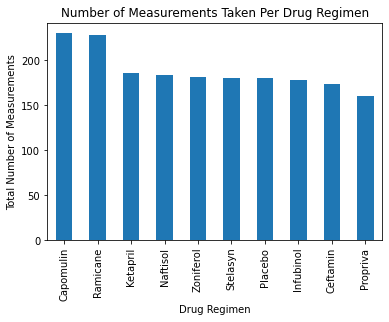

In [8]:
## BAR AND PIE CHARTS

## Create a bar chart using the .plot function and value_counts() function
## in order to plot the total number of measurements taken for each treatment regimen
reg_barplot = clean_df["Drug Regimen"].value_counts().plot(kind = "bar")
reg_barplot.set_xlabel("Drug Regimen")
reg_barplot.set_ylabel("Total Number of Measurements")
reg_barplot.set_title("Number of Measurements Taken Per Drug Regimen")
reg_barplot

Text(0.5, 1.0, 'Number of Measurements Taken Per Drug Regimen')

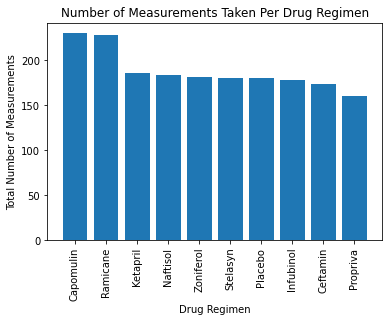

In [9]:
## Now do the same thing with pyplot
reg_count = clean_df["Drug Regimen"].value_counts()
x_axis = np.arange(len(reg_count))
tick_locations = [val for val in x_axis]
plt.bar(x_axis, reg_count)
plt.xticks( tick_locations, list(reg_count.index), rotation = "vertical")
plt.xlabel("Drug Regimen")
plt.ylabel("Total Number of Measurements")
plt.title("Number of Measurements Taken Per Drug Regimen")

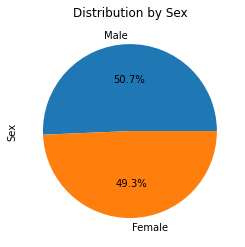

In [10]:
## Generate a pie plot showing the distribution of female versus male mice using Pandas
sex_count = clean_df["Sex"].value_counts()
sex_pieplot = sex_count.plot(kind = "pie", title = "Distribution by Sex", autopct="%1.1f%%")

Text(0.5, 1.0, 'Distribution by Sex')

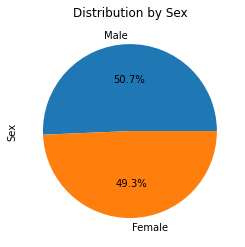

In [11]:
## Now do the same thing with pyplot
plt.pie(sex_count, labels = sex_count.index, autopct="%1.1f%%")
plt.ylabel("Sex")
plt.title("Distribution by Sex")

In [12]:
## QUARTILES, OUTLIERS, AND BOXPLOTS

# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

## Find the last timepoint for each mouse
max_timepoint_df = pd.DataFrame(clean_df.groupby('Mouse ID')["Timepoint"].max().sort_values()).rename(columns = {'Timepoint' : 'Max Timepoint'})

## Merge with cleaned dataframed
merge_max_time_df = pd.merge(clean_df, max_timepoint_df, on = "Mouse ID")
merge_max_time_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Max Timepoint
0,k403,Ramicane,Male,21,16,0,45.000000,0,45
1,k403,Ramicane,Male,21,16,5,38.825898,0,45
2,k403,Ramicane,Male,21,16,10,35.014271,1,45
3,k403,Ramicane,Male,21,16,15,34.223992,1,45
4,k403,Ramicane,Male,21,16,20,32.997729,1,45
...,...,...,...,...,...,...,...,...,...
1876,z969,Naftisol,Male,9,30,25,63.145652,2,45
1877,z969,Naftisol,Male,9,30,30,65.841013,3,45
1878,z969,Naftisol,Male,9,30,35,69.176246,4,45
1879,z969,Naftisol,Male,9,30,40,70.314904,4,45


In [13]:
## list for regimens, empty list to store volume values
regimens = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]
vol_values = []

## Loop through regimen and pull final timepoint values into df
for drug in regimens:
    drug_df = merge_max_time_df.loc[merge_max_time_df["Drug Regimen"] == drug]
    drug_final_time_df = drug_df.loc[drug_df["Timepoint"] == drug_df["Max Timepoint"]]
    
    ## Pull final tumor volumes into a list
    final_vol = drug_final_time_df["Tumor Volume (mm3)"]
    vol_values.append(final_vol)
    
    ## Calculate the IQR and quantitatively determine if there are any potential outliers
    quartiles = final_vol.quantile([0.25, 0.5, 0.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    print(f"The IQR for {drug} is: {iqr}")
    
    ## Determine Outliers and Bounds
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)
    print(f"The lower bound for {drug} is: {lower_bound} \nThe upper bound for {drug} is: {upper_bound}")
    print(f"Number of potential outliers for {drug}: {final_vol.loc[(final_vol <= lower_bound) | (final_vol >= upper_bound)].count()}\n")

The IQR for Capomulin is: 7.781863460000004
The lower bound for Capomulin is: 20.70456164999999 
The upper bound for Capomulin is: 51.83201549
Number of potential outliers for Capomulin: 0

The IQR for Ramicane is: 9.098536719999998
The lower bound for Ramicane is: 17.912664470000003 
The upper bound for Ramicane is: 54.30681135
Number of potential outliers for Ramicane: 0

The IQR for Infubinol is: 11.477135160000003
The lower bound for Infubinol is: 36.83290494999999 
The upper bound for Infubinol is: 82.74144559000001
Number of potential outliers for Infubinol: 1

The IQR for Ceftamin is: 8.57719978
The lower bound for Ceftamin is: 43.19194942 
The upper bound for Ceftamin is: 77.50074854
Number of potential outliers for Ceftamin: 0



Text(0.5, 1.0, 'Final Tumor Volume by Drug Regimen')

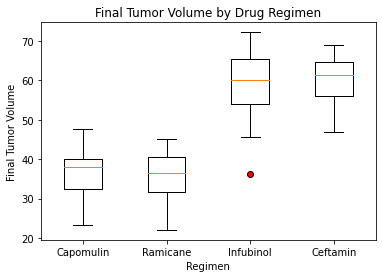

In [14]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
red_circle = dict(marker = 'o', markerfacecolor = 'red', markeredgecolor = 'black')
plt.boxplot(vol_values, flierprops = red_circle)
plt.xticks([1,2,3,4], regimens)
plt.ylabel("Final Tumor Volume")
plt.xlabel("Regimen")
plt.title("Final Tumor Volume by Drug Regimen")

Text(0.5, 1.0, 'Tumor Volume vs Time Point (Mouse ID x401)')

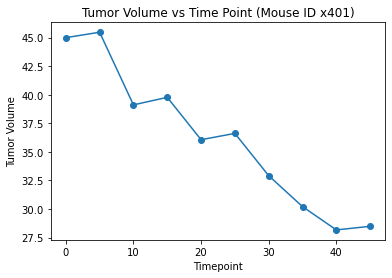

In [15]:
## LINE AND SCATTER PLOTS

## Pull data from a single mouse using Capomulin regimen
single_mouse_cap = clean_df.loc[clean_df["Mouse ID"] == "x401"]

## Put into line chart
plt.plot(single_mouse_cap["Timepoint"], single_mouse_cap["Tumor Volume (mm3)"], marker = 'o')
plt.xlabel("Timepoint")
plt.ylabel("Tumor Volume")
plt.title("Tumor Volume vs Time Point (Mouse ID x401)")

Text(0.5, 1.0, 'Average Tumor Volume vs Weight of Mice on Capomulin Regimen')

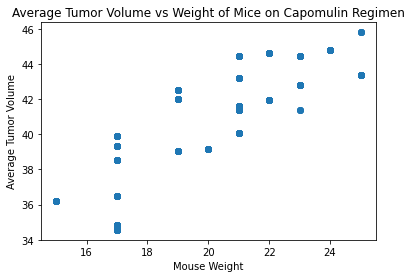

In [16]:
## Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
cap_reg = clean_df.loc[clean_df["Drug Regimen"] == "Capomulin"]

## Calc Average tumor volume, add into data frame
avg_col = cap_reg.groupby('Mouse ID')['Tumor Volume (mm3)'].mean()
avg_df = pd.DataFrame(avg_col)
## Merge into dataframe
merge_avg_df = pd.merge(clean_df, avg_df, on = 'Mouse ID').rename(columns = {"Tumor Volume (mm3)_y" : "Average Tumor Volume",
                                                                            "Tumor Volume (mm3)_x" : "Tumor Volume (mm3)"})

## Create scatter plot
plt.scatter(merge_avg_df["Weight (g)"], merge_avg_df["Average Tumor Volume"])
plt.xlabel("Mouse Weight")
plt.ylabel("Average Tumor Volume")
plt.title("Average Tumor Volume vs Weight of Mice on Capomulin Regimen")

The correlation coefficent between the average tumor volume and weight of mice on the Capomulin regimen is 0.834.


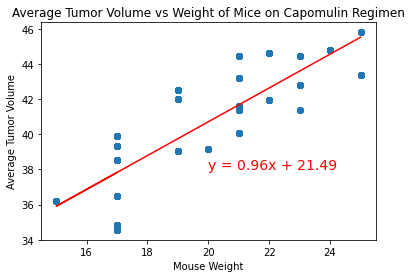

In [17]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
corr_coeff = st.pearsonr(merge_avg_df["Weight (g)"], merge_avg_df["Average Tumor Volume"])

## Linear Regression Model
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(merge_avg_df["Weight (g)"], merge_avg_df["Average Tumor Volume"])
regress_values = merge_avg_df["Weight (g)"] * slope + intercept
lin_eq = 'y = ' + str(round(slope, 2)) + 'x + ' +str(round(intercept, 2))
lin_eq

## Create the scatter plot
plt.scatter(merge_avg_df["Weight (g)"], merge_avg_df["Average Tumor Volume"])
plt.plot(merge_avg_df["Weight (g)"], regress_values, color = 'red')
plt.xlabel("Mouse Weight")
plt.ylabel("Average Tumor Volume")
plt.title("Average Tumor Volume vs Weight of Mice on Capomulin Regimen")
plt.annotate(lin_eq, (20,38), fontsize=14, color='red')
print(f"The correlation coefficent between the average tumor volume and weight of mice on the Capomulin regimen is {corr_coeff[0].round(3)}.")